# One-Way Markets: The Stochastic Block Model with a Bipartite Graph

James Yu, Vancouver School of Economics, 18 May 2021

with concepts from Dr. Michael Peters, VSE

In [28]:
import colorsys
import numpy as np
import requests

import graph_tool as gt
import graph_tool.inference.minimize as gtf
import graph_tool.draw as drw
import matplotlib.pyplot as plt

from base64 import b64encode 
from collections import defaultdict
from io import BytesIO
from IPython.display import HTML, Image as Im
from PIL import Image, ImageDraw

## Introduction

Traditionally, a market is a collection of buyers and sellers trading bilaterally in goods and utilities. Buyers seek to obtain products in exchange for providing a resource of equivalent value, either a different product or monetary resources. In these markets, nothing stops buyers from becoming sellers and vice-versa: for example, an individual could easily buy a mobile phone from a seller, use it for awhile, and then sell it back to someone else later on — perhaps even back to the original seller as part of a phone replacement buyback program which is all too common today.

One particular example of these "two-way markets", which will come into play in this notebook, is the global job market. In job markets, buyers are companies looking to hire employees, and sellers are individuals or institutions offering to work for those companies in exchange for wages. In many job markets, these are entirely in control of the individual themselves$^{[1]}$ whereas in a handful of job markets, these are influenced or backed up by the institution a candidate employee is currently located in$^{[2]}$. Here I focus on the latter to reinforce the concept of "two-way".

Consider the market for individuals with a PhD in economics, which is a highly dynamic market. At UBC, economics PhD students nearing the end of their degree usually compose a "job market paper", with the guidance of department faculty and peers, for the purpose of demonstrating one's abilities to potential employers around the world. From there, different institutions, academic and commercial, may be interested in hiring this PhD student from UBC, which leads to a market transaction of hiring said student for some wage. Suppose they are hired at one such university henceforth called the second institution.

This transaction between UBC and the second institution may kickstart a long chain of future transactions. The now-employed student may soon find themselves being hired at a different institution, perhaps with a higher-ranked academic role, which constitutes a transition from one employment position to another. The choice of this new, third institution to hire the student would be influenced by their performance in the second institution combined with any from before. This can repeat endlessly, and the student may even find themselves being hired back at UBC someday.

The fact that nothing prevents a student from eventually being hired at the institution they graduated from makes this a "two-way" market. Buyers and sellers in this market are interchangeable as the buyers looking to hire students are also sellers reinforcing the students' curriculum vitae. Indeed, nothing prevents two institutions from exchanging employees for the exact same positions, if perhaps locations or academic communities are more preferable for the two involved.

However, within this "two-way" academic job market lies a secondary market acting as the driving force for all other transactions. The initial step of a new PhD graduate being hired at their very first position is in itself a sub-market of the global market. The hiring process for PhDs is not precisely the same as that for experienced professors, as the experience and employment length of individuals in these two categories is very different. This, combined with the fact that every hiring sequence for every PhD starts with the PhD being hired from their original institution, constitutes this process as an approximately independent sub-market$^{[3]}$. I focus on the properties of this sub-market in this notebook.

<sub><sup>$[1]$: See UBC's TA hiring process.</sup></sub>\
<sub><sup>$[2]$: See UBC's Co-Op program, the concept of a PhD "job market paper", etc.</sup></sub>\
<sub><sup>$[3]$: PhD graduates may in many cases compete with experienced employees for various positions around the world, which introduces dependence. However, as the focus of the notebook is to evaluate the market structure of PhD-initial placements, this dependency can be treated as an externality.</sup></sub>

## The One-Way Market

The market which newly-graduated economics PhD students find themselves in can be characterized as a "one-way" market. While the overall job market is a "two-way" market in the sense that institutions can hire and send individuals between themselves, the PhD market is a "no returns, no refunds" environment. Once someone is hired for the first time, that transaction is set in history, and the individual can never again be hired for the "first time" with no prior employment experience, as now they have experience from this new job.

Another way to think about this is to consider the current title of a new PhD graduate as "PhD graduate". When the student is in the job market, they carry around this title and use the experience that comes with it to apply to various jobs. Once they are finally hired somewhere, they no longer carry this title and instead carry the title of their new position (e.g. lecturer, assistant professor, consultant, etc). As it is impossible for an individual to go from this new title backwards to having the exclusive title of "PhD graduate" with no experience, this title-switch is one-way. Thus, the market for PhD graduates can be thought as a one-way market for individuals that have just recently obtained their PhD diplomas and have not been hired anywhere else yet. 

Because the market is one-way, the set of all sellers and the set of all buyers are entirely independent. That is, the institutions graduating PhD students are all on one side of the market, and the institutions hiring them are all on another side of the market. Indeed, many institutions both serve as a source of graduating students and as an institution that hires students, but I consider these to be separate entities: the graduating functions of the institution are a separate entity from the hiring functions, because the nature of each position has different characteristics.

Since I have two classifications of institutions, buyers and sellers, I can illustrate the market using a bipartite directed graph, where institutions on one side are sellers and institutions on the other are buyers looking to hire students. Edges in the graph are directed from one seller to one buyer representing a job acceptance transaction as mentioned before. For example, I could have the following miniature PhD market:

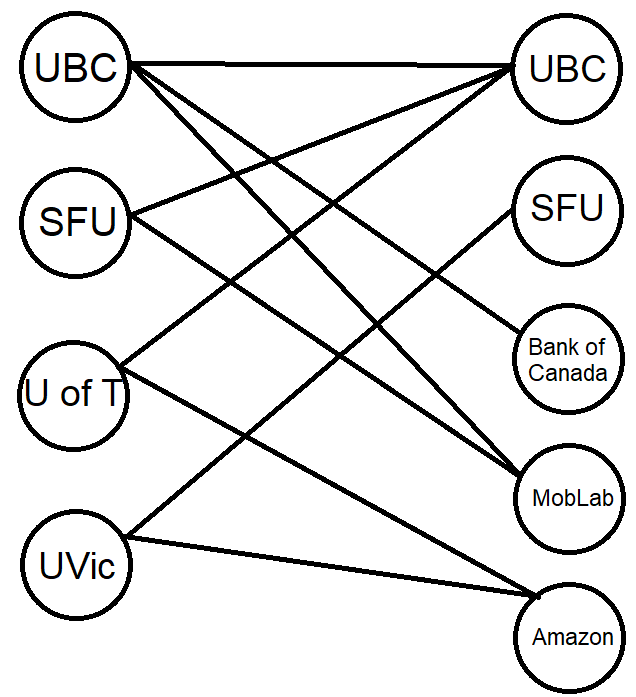

In [4]:
Im(filename = "figure_1.png", width = 300, height = 300)

(Figure 1: Example model of a bipartite one-way market. The nodes on the left represent institutions graduating PhD students, and the nodes on the right represent institutions hiring them. Each edge is a directed edge towards the hiring institutions representing at least one job transaction/hire from the graduating node to the hiring node.)

This once again begs the question of why not group all the nodes with the same name together. After all, wouldn't individuals being hired and sent out from the same institution deserve more weight than institutions that only do one of the two?

The answer is simultaneously yes and no. It is yes in the sense that in the scope of the global job market, higher performance leads to higher reputation which leads to more transactions. However, this requires the existence of future job transitions after the initial post-PhD transition. In the scope of this one-way market, I am not able to comment on these external factors as they do not locally exist, and therefore I treat them as externalities in terms of their influence on hirings rather than as an endogenous weight. Thus, I keep the nodes separate, since inherently they serve separate purposes.

Given my representation of the one-way market, the next step is to analyze its composition to determine what the real market actually may look like.

## The Stochastic Block Model

The stochastic block model, henceforth SBM, is a framework for extracting information from networks regarding communities of common traits. For example, a social media network is composed of various sub-communities centered around various common interests such as photography, politics or parties. The goal of the SBM is to extract these communities given only information about the observed structure of the network as a whole: given information about who communicates with whom, SBM would attempt to classify particular individuals based on interactions with other common subsets of other individuals.

This concept can be easily applied to job markets, as done by Gyetvay (2021). Given my one-way market as above, I might expect certain institutions to have a tendency to send students to the same places as other institutions. For example, I could hypothesize that top-ranked universities, being well-regarded across the world, would have a tendency to send PhD students to other top universities. I could also hypothesize the reverse: top universities might only accept students from other top universities.

SBM itself works by taking the network as-is and attempting to fit "blocks" which categorize groups of nodes together. Peixoto (2014a, 2014b) outlines and implements the procedure in great detail. Starting with a guess-partition of the network into "blocks" where each node has its own block, a stochastic update step is applied which attempts to merge blocks together. A likelihood function, which is inversely related to the number of blocks, is used to determine greedily which of the randomly selected update steps most optimally improve the partition, with the goal being to find the communiuty partition that is most likely that of reality (e.g. in the social media example, to recover the individual sub-communities). 

By applying SBM to the one-way market, I expect to be able to recover **communities of institutions which either frequently send to the same institutions as others, or frequently receive hires from the same institutions as others**. To do this, a dataset must first be processed.

## EconJobMarket

EconJobMarket is a not-for-profit institution which supports the placement of employment candidates in over 1500 institutions worldwide (EconJobMarket, 2021). As part of individuals making accounts with their website and being hired by institutions after graduating, a record of job placements is kept online. Combined with searching the CVs of individuals who do not have placement records on EconJobMarket, a dataset can be extrapolated by collecting anonymized versions of these flows between institutions. In June 2020, Amedeus D'Souza and various other honours students at the Vancouver School of Economics worked to enhance and collect this dataset, which can be found at [https://github.com/michaelpetersubc/job_market_data/blob/master/to_from_data.json](https://github.com/michaelpetersubc/job_market_data/blob/master/to_from_data.json). Here I use this dataset to initialize my model of the one-way market for PhD students, where source universities are extracted from the "from_institution" fields, and destination (hiring) universities are extracted from the "to_institution" fields.

## Getting Around Biases

One issue with taking the raw data as-is is that numerous inherent biases are present. As explained by D'Souza (2020), the original to-from flows data is imbalanced in terms of the number of data records obtained from western institutions versus eastern institutions. Additionally, as some institutions do not post placement records, the incomplete 2020 records may have less available records for some institutions than others. The latter issue is being rectified with the collection of additional data, while the former issue can be rectified by limiting source institutions to exclusively the top 100 worldwide. While this may seem counterintuitive, all that needs to be analyzed is the composition of the market of institutions that are available, rather than those that are not. The ones that are not included still influence the market in terms of taking positions that could otherwise have been taken by students that records exist for, so the presence of these "hidden" institutions is still present as an externality. Additionally, as it turns out later on, there are rough geographic partititons between select sub-markets for institutions that graduate PhDs, so this exclusion has minimal impact on the results that follow.

To get the top 100 institutions, I use a compilation also obtained by D'Souza (2020) which collects the top 100 as outlined by Tilburg University in terms of research contributions over the past few years. I extract this dataset and apply it to the to-from dataset as follows:

In [8]:
def collect_data():
    institution_names = []
    ordered_ids = []
    ranks = requests.get("https://raw.githubusercontent.com/michaelpetersubc/job_market_data/master/tilberg_rankings.json").json()
    for rank in ranks:
        institution_names.append([rank["ejm_institution_id"], rank["rank"]])

    institution_names.sort(key = lambda x: x[1])
    ordered_ids = [i[0] for i in institution_names]

    flows = []
    ids_to_names_source = {}
    ids_to_names_dest = {}
    to_from = requests.get("https://raw.githubusercontent.com/michaelpetersubc/job_market_data/master/to_from_data.json").json()
    for result in to_from:
        if result["from_institution_id"] in ordered_ids:
            flows.append([result["from_institution_id"], result["to_institution_id"]])
            ids_to_names_source[result["from_institution_id"]] = result["from_institution_name"] + "(PhD)"
            ids_to_names_dest[result["to_institution_id"]] = result["to_name"] + "(Employed)"

    institutions = list(ids_to_names_source.keys())
    institutions.sort(key = lambda x: ordered_ids.index(x) if x in ordered_ids else len(ordered_ids))
    return institutions, flows, ids_to_names_source, ids_to_names_dest

institutions, flows, ids_to_names_source,  ids_to_names_dest = collect_data()
print(len(ids_to_names_source))
print(len(ids_to_names_dest))
print(len(flows))

83
826
4225


## Visualizing the Market

According to the output, as of the time of writing, there are 83 source institutions that sent students out that were in the top 100, as well as a total of 826 institutions that hired students. A total of 4225 job flows were recorded between sources and destinations.

One way to represent the flow of individuals from sources to destinations is to plot an adjacency matrix, where a dot represents a flow from source to destination and the heaviness represents more students that followed the same path. I construct such a matrix as follows:

In [12]:
A = np.zeros((len(institutions), len(institutions)))
for flow in flows:
    if flow[1] in institutions:
        A[institutions.index(flow[0]), institutions.index(flow[1])] += 1
A

array([[6., 5., 8., ..., 0., 0., 0.],
       [2., 4., 3., ..., 0., 0., 0.],
       [7., 7., 5., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

This matrix can be graphed as follows:


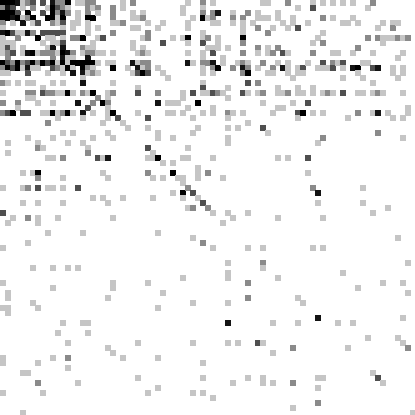

In [13]:
highest = np.max(A)
img = Image.new("RGBA", (5*len(institutions), 5*len(institutions)), (255, 255, 255, 255))
draw = ImageDraw.Draw(img)
for i in range(len(institutions)):
    for j in range(len(institutions)):
        weight = A[j, i]
        scl = 255 - int(weight*2000 // highest)
        col = (scl, scl, scl)
        if col != (255, 255, 255):
            draw.rectangle((5*i, 5*j, 5*(i+1), 5*(j+1)), fill = col, outline = col)
            
#draw.rectangle((5*42, 0, 5*43, 5*len(institutions)), fill = (0,0,255,255), outline = (0,0,255,255)) # identifies the UBC line right before this line   
filex = BytesIO()
img.save(filex, "PNG")
HTML(f"<img src='data:image/png;base64,{b64encode(filex.getvalue()).decode('utf-8')}'/>")

The rows here represent the top 83 source institutions in ranked order, and the columns represent those same 83 institutions in the same order, albeit accepting students instead of graduating them. What the chart indicates is that the very top few institutions have a tendency to frequently send students to other institutions in this same "top circle", while also sending students out to lower-ranked institutions. There is also a faint but present diagonal, representing institutions that hire their own students, and there are rough vertical lines present representing lower-ranked institutions which hire from a diverse range of higher-ranked institutions.

## The SBM Algorithm in Practice

The variant of SBM to be used on this data is taken from the `graph-tool` library created by Peixoto (2014) and used by Gyetvay (2021). The algorithm is run by calling `minimize_nested_blockmodel_dl`, which executes the degree-corrected SBM variant as outlined by Peixoto (2014) with an extra step of applying SBM recursively in order to generate "hypermarkets", or markets which have sub-markets in them as identified by Gyetvay (2021). Here the algorithm is run multiple times as explained in `graph-tool`'s documentation, which is necessary to extract as accurate a result as possible due to the stochastic nature of the algorithm. The most optimal outcome, or the one with least entropy, is the one taken as a result.

The inputs to the algorithm are simply the to-from edge flows from the dataset, which represent directed movements between nodes (institutions).

In [14]:
source_ids = list(ids_to_names_source.keys())
sink_ids = list(ids_to_names_dest.keys())
new_flows = [[source_ids.index(f[0]), sink_ids.index(f[1]) + len(source_ids)] for f in flows]

len(new_flows)

4225

Given this, I run 1000 iterations of nested SBM on a bipartite directed graph created using these flows. When finished, I print out the "entropy" of the system, which is equivalent to the negative of the likelihood and is the optimization target for the model. A minimized entropy, as in Peixoto (2014), corresponds to the most likely partition of the network.

In [66]:
def SBM2(edge_set, iterations = 1000, debug = False):
    g = gt.Graph(directed=True)
    g.add_edge_list(edge_set)
    beststate = None
    smallest = np.inf
    for i in range(iterations):
        if debug: print(i)
        state = gtf.minimize_nested_blockmodel_dl(g, deg_corr=True)
        if state.entropy() < smallest:
            smallest = state.entropy()
            beststate = state
            
    return g, beststate, smallest

g3, state3, entropy3 = SBM2(new_flows, debug = True)
print(entropy3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27


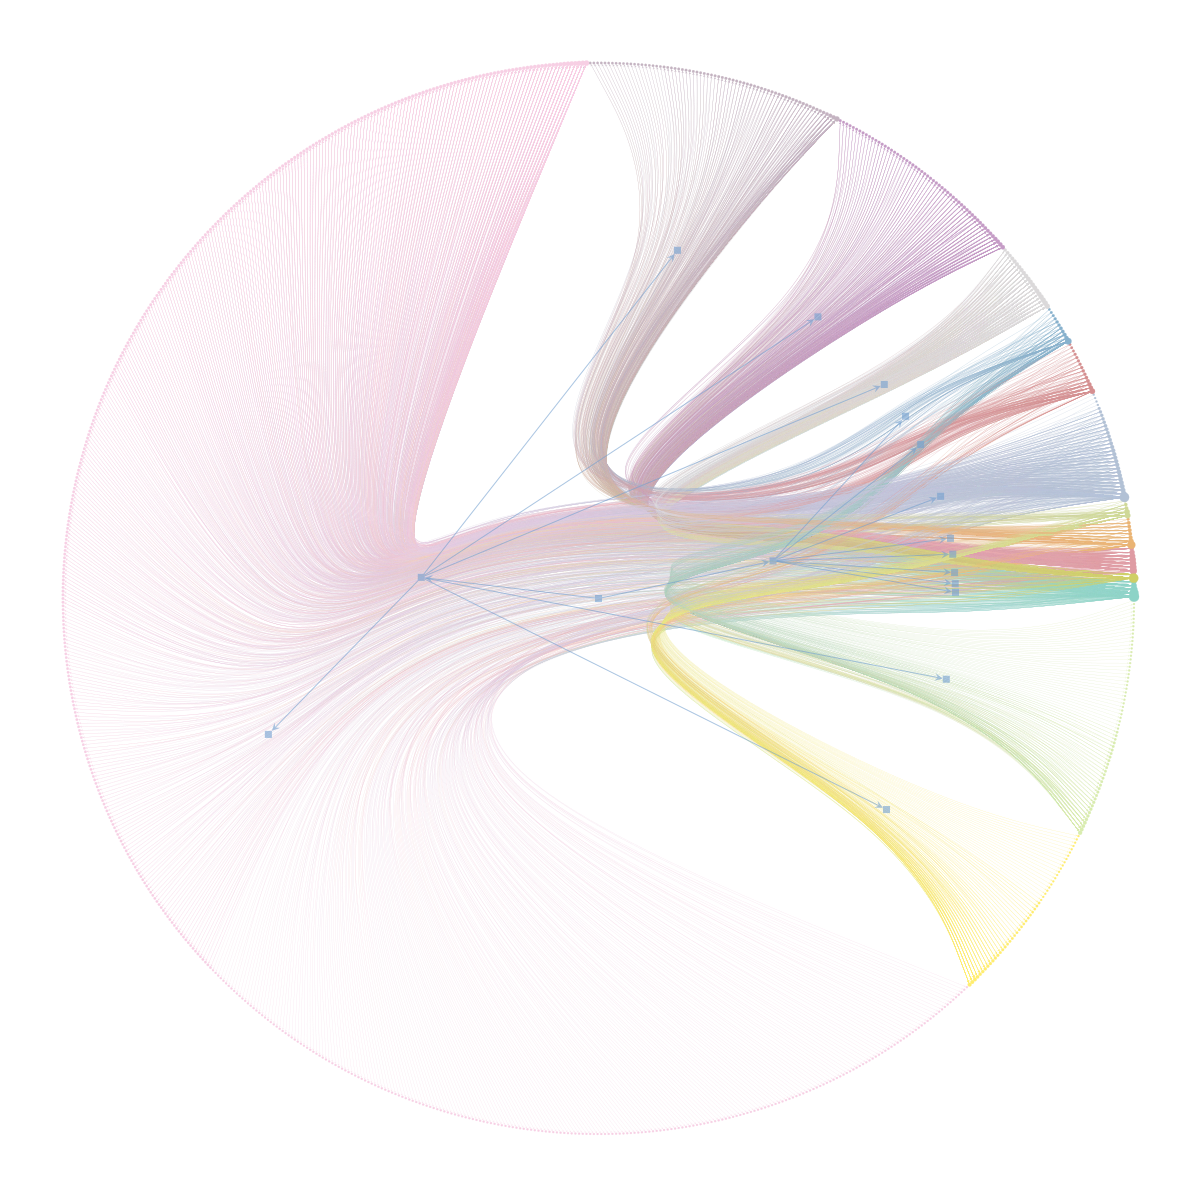

In [68]:
filex3 = BytesIO()
state3.draw(output=filex3, fmt = "png")
filex3.seek(0)
HTML(f"<img src='data:image/png;base64,{b64encode(filex3.getvalue()).decode('utf-8')}'/>")

In [70]:
state3.get_levels()

[<BlockState object with 14 blocks (14 nonempty), degree-corrected, for graph <Graph object, directed, with 909 vertices and 4225 edges, at 0x7f4c416c84c0>, at 0x7f4c40fa3070>,
 <BlockState object with 2 blocks (2 nonempty), for graph <Graph object, directed, with 14 vertices and 48 edges, 2 internal vertex properties, 1 internal edge property, at 0x7f4c40fa3c40>, at 0x7f4c40f37a30>,
 <BlockState object with 1 blocks (1 nonempty), for graph <Graph object, directed, with 2 vertices and 1 edge, 2 internal vertex properties, 1 internal edge property, at 0x7f4c40f870d0>, at 0x7f4c414ce580>]

The outermost level has only one block, so I can parse the other levels to determine what the structure is.

In [97]:
levels = state3.get_levels()
submarkets = levels[0]
submarket_level = defaultdict(list)
for i, block in enumerate(submarkets.get_blocks()):
    if i >= 83:
        if sink_ids[i - 83] in ids_to_names_source:
            name = ids_to_names_dest[sink_ids[i - 83]]
            submarket_level[block].append(name)
    else:
        name = ids_to_names_source[source_ids[i]]
        submarket_level[block].append(name)
    
dict(submarket_level)

{0: ['University of Michigan(PhD)',
  'University of California Los Angeles (UCLA)(PhD)',
  'Duke University(PhD)',
  'Columbia University(PhD)',
  'University of Pennsylvania(PhD)'],
 1: ['University of Maryland(PhD)',
  'Brown University(PhD)',
  'Boston University(PhD)',
  'University of Toronto(PhD)',
  'Michigan State University(PhD)',
  'Washington University in St. Louis(PhD)',
  'University of Wisconsin, Madison(PhD)',
  'Purdue University(PhD)',
  'University of Washington(PhD)',
  'University of Notre Dame(PhD)',
  'Pennsylvania State University(PhD)',
  'Boston College(PhD)',
  'Vanderbilt University(PhD)',
  'George Washington University(PhD)',
  'Ohio State University(PhD)',
  'Texas A&M University, College Station(PhD)',
  'Singapore Management University(PhD)',
  'National University of Singapore(PhD)',
  'Cornell University(PhD)',
  'University of Southern California(PhD)',
  'Hong Kong University of Science and Technology(PhD)',
  'Carnegie Mellon University(PhD)',
  '

The first thing to note is that there are relatively clear labels that we can give these blocks. If you search up the rankings and locations of each university, the blocks can generally be classified as follows:

- Block 0 + Block 1: intermediately ranked American universities\
- Block 2 + Block 7: high ranked American universities\
- Block 3: intermediately ranked European universities plus UBC, SFU\
- Block 4: high ranked European universities\
- Block 5: Oceania-region universities\
- Block 6: roughly intermediate European-ish universities

I also observe:

- Block 8: tight-knit international catch-all market for institutions which tend to send students globally\
- Block 9: high ranked American universities\
- Block 10: intermediately ranked American universities\
- Block 11: high ranked European universities\
- Block 12: Oceania-region universities\
- Block 13: intermediately ranked European universities

Next, I can render the transition matrix, which represents the number of flows between blocks.

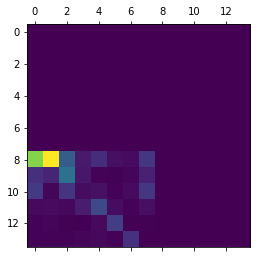

In [76]:
transition = submarkets.get_matrix()
plt.matshow(transition.todense())

Numerically, the matrix is:

In [83]:
transition.todense()

matrix([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [703., 862., 255.,  62., 112.,  36.,  24., 139.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [117.,  88., 325.,  57.,  10.,   4.,  11.,  78.,   0.,   0.,
    

I can iterate row by row and column by column to see what this says about the flows of the job market.

Column zero and one together represents intermediate americans. Together, they both predominantly send students to the uniform international block (block 8), but the universities in the smaller American block have a higher tendency (117+148) to send students to blocks 9 and 10, which are high and intermediate American universities. What I can conclude is that most Americans uniformly go internationally, but a particular subset has a greater tendency to remain local.

Column two is high ranked American institutions, which mostly sends to the high ranked American employment institutions (325 flows). Second after that is the uniform global block (255 flows) and the intermediate american block (132 flows). Thus, high ranked American institutions mostly send to institutions that are highly ranked, but are also globally prolific as well.

Column three is intermediate Europe, which is uniform across global, high ranking America and high ranking Europe. Some institutions in block three are slightly higher ranked (LSE), so this is explained.

**NOTE:** At this point it becomes important to note why these blocks are not black and white partitions. The blocks are not meant to represent institutions with the same traits. This is simply a nice side effect of the partition. Instead, they are meant to represent institutions whom together share the same sets of institutions they send students to, or vice versa. That is, they together form a local sub-market, which may not perfectly follow black and white partitions.

Column four is high ranked Europe, which mostly sends to the global uniform market as well as block 11, which is the high-ranked Europe employment set. Thus, high-ranking Europe mostly sends to itself.

Column five is Oceania, which mostly sends to Oceania.

Column six is a separate intermediate Europe subset, which mostly sends to another very specific European subset (block 13). This would be indicative of an isolated sub-market.

Column seven falls under column two's categorization, but instead of sending to block 9, it only sends to 8 and 10. This means it is essentially suppressed from sending to the highest American institutions and mostly sends either globally or intermediately.

I can also do this analysis going through the rows first as follows:

Row eight, the global uniform block, mostly draws from America (703, 862, 255). There are some draws from Europe, but far less.

Row nine, the high-ranking American block, mostly draws from itself and block zero (higher intermediate America). There are smaller draws from other parts of America as well.

Row ten, the intermediate American block, mostly draws from block 0 and block 2, which are intermediate-high to high ranking American blocks. This means intermediately-ranked institutions in America mostly hire students from the higher-ranked institutions, while those from intermediate ones end up hired in the global pool as previously analyzed.

Row eleven, high-ranking Europe, mostly draws from high-ranking Europe.

Row twelve, Oceania, mostly draws from Oceania.

Row thirteen, the isolated European auxiliary block, largely draws from the corresponding isolated European auxiliary block 6, but also from other parts of Europe.

## Conclusions

The nested SBM model was able to directly isolate nodes for source universities and sink universities into separate blocks. Within these blocks, I found partitions based on both geography and academic rank, as well as at least one isolated sub-market in Europe, and a uniform global pool which America predominantly supplies.

The nested SBM model's only function is to generate this partition as a "recommendation" for how to group universities together. The actual data I used to make these comments about which institutions send where comes directly from the data itself, as the block transition matrix is supplied by the data flows that generated it. This means that, if one wanted to adjust the block partitions, they would easily be able to do so and see the results appear in the block transition matrix.

Going forward, this data can be used to analyze shocks to different aspects of the market, with the goal being observing how these shocks propagate across market boundaries.

## Works Cited/Consulted

D'Souza, A. and Peters, M. (2020). "Mapinator". GitHub repository, [https://github.com/michaelpetersubc/mapinator](https://github.com/michaelpetersubc/mapinator)\
D'Souza, A. and Peters, M. (2020). "Job Market Data". GitHub repository, [https://github.com/michaelpetersubc/job_market_data/blob/master/data_description.ipynb](https://github.com/michaelpetersubc/job_market_data/blob/master/data_description.ipynb)\
Gyetvay, S. (2021). "Immigration in Overlapping Labour Markets". Personal collection of S. Gyetvay, Vancouver School of Economics, UBC, Vancouver, BC.\
(2021). "Statistics", Econ Job Market Inc. Retrieved 18 May 2021, from [https://econjobmarket.org/stats](https://econjobmarket.org/stats)\
Peixoto, T. (2014). "Efficient Monte Carlo and greedy heuristic for the inference of stochastic block models", Physical Review E. DOI: [10.1103/PhysRevE.89.012804](http://dx.doi.org/10.1103/PhysRevE.89.012804)\
Peixoto, T. (2014). "Hierarchical Block Structures and High-Resolution Model Selection in Large Networks", Physical Review X. DOI: [10.1103/PhysRevX.4.011047](https://dx.doi.org/10.1103/PhysRevX.4.011047)\
Peixoto, T. (2014). "The graph-tool python library", figshare. DOI: [10.6084/m9.figshare.1164194](https://dx.doi.org/10.6084/m9.figshare.1164194)